# Modeling - First Pass

### Installs, Packages, Seeds

In [160]:
%pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [161]:
%pip install torch
# %pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [162]:
%matplotlib inline

# python libraties
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns
from itertools import combinations, product

# import imblearn
import logging
from tqdm import tqdm
from glob import glob
from PIL import Image
import ipywidgets

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
from efficientnet_pytorch import EfficientNet

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# google drive
# from google.colab import drive # Connect colab to google drive

# custom modeling libraries
from build_model2 import initialize_model, load_split_data, build_loader, evaluate, train_model, model_scores, eval_model, add_results

# other
import importlib

In [163]:
import build_model2
importlib.reload(build_model2)

from build_model2 import initialize_model, load_split_data, build_loader, evaluate, train_model, model_scores, eval_model, add_results

# import matplotlib as mpl
# print(mpl.get_cachedir())

## Parameters

In [164]:
model_dict = {'pretrained_model': 'resnet',
              'epochs': 3,
              'home_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone',
              'mod_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone/model/gridsearch',
              'csv_name': 'full_data_rename',
              'split': 'split_3',
              'cl': 'label_0',
              'dev_state': False,
              'dev_sample': 15000,
              'seed': 99,
              'lr': .002,
              'batch_size':3, #64
              'num_workers':24,
              'transform_set':'a',
              'results_file':'result_test'
             }

np.random.seed(model_dict['seed'])
torch.cuda.manual_seed(model_dict['seed'])

# Check GPU
print('GPU Type:', torch.cuda.get_device_name())
print('GPU Count:', torch.cuda.device_count())

GPU Type: Tesla T4
GPU Count: 1


## Data

In [165]:
data, train, test, val = load_split_data(directory = model_dict['home_directory'],
                                         csv_name = model_dict['csv_name'], 
                                         data_split = model_dict['split'], 
                                         label = model_dict['cl'],
                                         mode = 'all',
                                         dev_state = model_dict['dev_state'], 
                                         dev_sample = model_dict['dev_sample'], 
                                         seed = model_dict['seed']
                                         )

## Modeling

In [166]:
model_dict['pretrained_model'] = 'vgg'

In [167]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name = model_dict['pretrained_model'], 
                                        num_classes = len(data.label.unique()),
                                        feature_extract = False, 
                                        use_pretrained=True)

# Define GPU:
device = torch.device('cuda:0')

# Move model to GPU
model = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

After model is defined, add final Parameters

In [168]:
input_size

224

In [169]:
# add some params after model definition
model_dict.update({'model':model,
                   'device':device,
                   'optimizer': optim.SGD(model.parameters(), lr=model_dict['lr']),
#                    'optimizer': optim.Adam(model.parameters(), lr=model_dict['lr']),
#                    'optimizer': optim.AdamW(model.parameters(), lr=model_dict['lr']),
                   'criterion': nn.CrossEntropyLoss().to(device),
                   'tuned_model_name':'resnet_split3_3e_Ta',})

In [170]:
resize = int(input_size/.85)
resize


263

In [171]:
transform_header = [
                    transforms.Resize(resize), #255
                    transforms.CenterCrop(input_size)
                    ]

transform_body = [
                  transforms.RandomHorizontalFlip(), # a
                  transforms.RandomVerticalFlip(), # b
                  transforms.RandomRotation(20), # c
                  transforms.RandomCrop(size=(input_size,input_size)), # d
                  transforms.RandomInvert(), transforms.RandomPosterize(bits=2), # e
                  transforms.RandomAdjustSharpness(sharpness_factor=2), # f
                  transforms.RandomSolarize(threshold=192.0), # g
                  transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1) # h
                  ]

transform_footer = [transforms.ToTensor(), 
                  transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])]

In [172]:
# transform_list = transform_header + transform_body + transform_footer

In [173]:
# using torch vision 'transforms'
# train_transform = transforms.Compose(transform_list)
# define the transformation of the val images. also used for test
val_transform = transforms.Compose([
                                      transforms.Resize(resize),
                                      transforms.CenterCrop(input_size),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                    ])

In [174]:
# tdf['transform'][0]

In [175]:
trans = [0, 1, 2, 3, 4, 5, 6, 7]
lrs = [.001, .0015, .002, .0025, .003, .0035, .004]
prods = list(product(trans, lrs))

trans_num = pd.Series(list(zip(*prods))[0], name = 'transform', dtype = 'int')
learn_rate = pd.Series(list(zip(*prods))[1], name = 'lr')
tdf = pd.concat([trans_num, learn_rate], axis = 1)
tdf['accur'] = pd.Series(dtype = 'float')
tdf['accur_0'] = pd.Series(dtype = 'float')
tdf['accur_1'] = pd.Series(dtype = 'float')
tdf['accur_2'] = pd.Series(dtype = 'float')
tdf['accur_3'] = pd.Series(dtype = 'float')
tdf['accur_4'] = pd.Series(dtype = 'float')
tdf['accur_5'] = pd.Series(dtype = 'float')

### Assemble data loaders

Run the model

In [176]:
HOME = model_dict['home_directory']

In [177]:
cd $HOME

/home/ec2-user/SageMaker/teledermatologyAI_capstone


In [178]:
tdf = tdf.iloc[:1]

In [179]:
tdf

,transform,lr,accur,accur_0,accur_1,accur_2,accur_3,accur_4,accur_5
0,0,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Train Sequence

In [180]:
model_dict['epochs'] = 1


Starting Training trials0
[epoch 1], [iter 100 of 4500],[train loss 1.54395], [train acc 0.24000]
[epoch 1], [iter 200 of 4500],[train loss 1.45168], [train acc 0.32833]
[epoch 1], [iter 300 of 4500],[train loss 1.38775], [train acc 0.37222]
[epoch 1], [iter 400 of 4500],[train loss 1.34528], [train acc 0.40500]
[epoch 1], [iter 500 of 4500],[train loss 1.32412], [train acc 0.42067]
[epoch 1], [iter 600 of 4500],[train loss 1.29396], [train acc 0.43556]
[epoch 1], [iter 700 of 4500],[train loss 1.28159], [train acc 0.44286]
[epoch 1], [iter 800 of 4500],[train loss 1.25889], [train acc 0.45875]
[epoch 1], [iter 900 of 4500],[train loss 1.24333], [train acc 0.46778]
[epoch 1], [iter 1000 of 4500],[train loss 1.22573], [train acc 0.47900]
[epoch 1], [iter 1100 of 4500],[train loss 1.21783], [train acc 0.48333]
[epoch 1], [iter 1200 of 4500],[train loss 1.21442], [train acc 0.48972]
[epoch 1], [iter 1300 of 4500],[train loss 1.21319], [train acc 0.49179]
[epoch 1], [iter 1400 of 4500],[tr

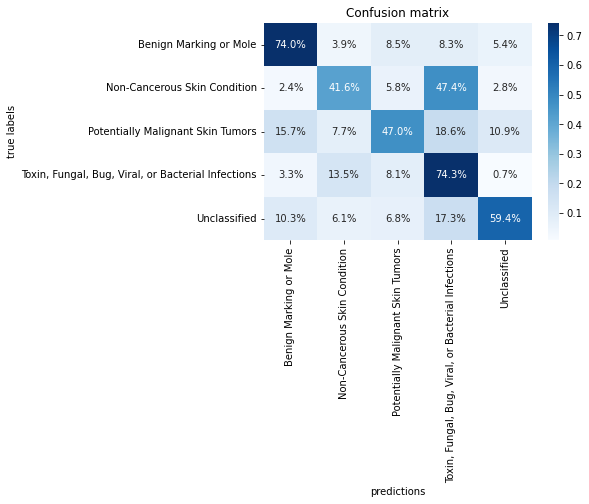


EPOCH 1 :
*****************************************************
Complete in 4m 10s
best record: [epoch 1], [val loss 0.98366], [val acc 0.59296]
*****************************************************

Total run Complete in 4m 10s


In [181]:
test_loader = build_loader(mode = 'test', df = test, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])
val_loader = build_loader(mode = 'val', df = val, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])

# Label dictionary for evaluation
labels_idx = np.sort(data.label_idx.unique())
label_map = data[['label', 'label_idx']].drop_duplicates().sort_values('label_idx')
label_dict = dict(zip(label_map.label_idx, label_map['label']))
model_dict['label_dict'] = label_dict

for i in tdf.iterrows():
    t_num = int(i[1]['transform'])
    lr = i[1]['lr']
    
    model_dict['alias'] = i[0]
    model_dict['transform'] = t_num
    model_dict['lr'] = lr
    model_dict['tuned_model_name'] = f'trials{i[0]}'
    
    transform_list = transform_header + [transform_body[t_num]] + transform_footer
    train_transform = transforms.Compose(transform_list)
    train_loader = build_loader(mode = 'train', df = train, transform = train_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])


    loaders = {'train_loader':train_loader,
                            'val_loader': val_loader,
                            'test_loader': test_loader}
    model_dict['loader'] = loaders

    pred_df, val_scores, tot_time = train_model(model_dict = model_dict)
    
#     pred_df = evaluate(model_name = f'gridsearch/resnet_split3_3e_GS{i[0]}', 
#                    model_source = 'pt', 
#                    model_dict = model_dict, 
#                    label_dict = label_dict, 
#                    show_cm = True)
    
#     acc = len(pred_df[pred_df.lab_idx==pred_df.pred_idx])/len(pred_df)

    acc, f1, f2, f5, prec, rec, d_0, d_1, d_2, d_3, d_4 = val_scores
    
#     tdf.at[i[0], 'accur'] = acc
    
    direc = model_dict['mod_directory']
    nam = model_dict['tuned_model_name']
    pred_df.to_pickle(f'{direc}/{nam}_preds.pkl')
    
    col_dict = {
#              'model': pd.Series(dtype = 'int'),
#              'file': pd.Series(dtype = 'str'),
             'tuned_model': model_dict['tuned_model_name'],
             'transform': model_dict['transform'],
             'lr': model_dict['lr'],
             'pretrained_model': model_dict['pretrained_model'],
             'optimizer': model_dict['optimizer'],
             'epochs': model_dict['epochs'],
#              'num_classes': model_dict['num_classes'],
             'batch_size': model_dict['batch_size'],
             'workers': model_dict['num_workers'],
             'train_time': tot_time,
             'data_split': model_dict['split'],
             'label_set': model_dict['cl'],
             'accur': acc,
             'F1': f1,
             'F0.5': f5,
             'F2': f2,
             'benign_accur': d_0,
             'noncancerous_accur': d_1,
             'malignant_accur': d_2,
             'infection_accur': d_3,
             'unclassified_accur': d_4
    }
    
#     print(tdf.iloc[:i[0]+1][['transform', 'lr', 'accur']])
    add_results(model_dict['results_file'], direc, pd.DataFrame(col_dict, index = [i[0]]))

## Evaluate

In [182]:
# # resnet_split3_3e
# pred_df = evaluate(model_name = 'resnet_split3_3e_2', 
#                    model_source = 'pt', 
#                    model_dict = model_dict, 
#                    label_dict = label_dict, 
#                    show_cm = False)